# ✍️ OCR of Handwritten Digits — OpenCV + Deep Learning
**Image:** `digits1.png`

## Step‑by‑Step Plan
1) Setup & imports
2) Load image & visualize
3) Preprocess (gray→blur→threshold→morph)
4) Contours & boxes (sorted)
5) Extract 28×28 crops (MNIST‑style)
6) CNN model on MNIST (quick fit or load weights)
7) Predict and overlay
8) Save artifacts

### 1) Setup & imports

In [2]:
# !pip install opencv-python-headless numpy pandas matplotlib tensorflow scikit-learn joblib
import cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
plt.rcParams['figure.figsize']=(8,6)
tf.random.set_seed(42)

### 2) Load image & visualize

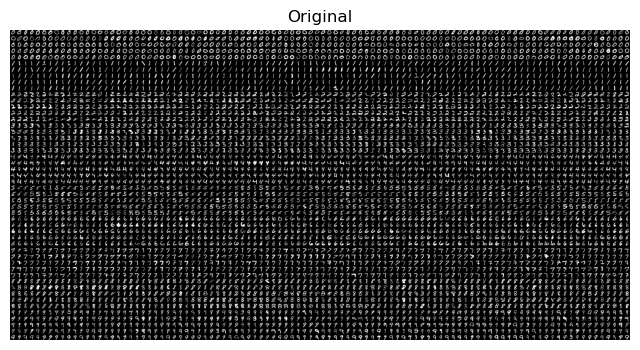

In [3]:
IMG_PATH = 'digits1.png'
orig = cv2.imread(IMG_PATH)
if orig is None:
    raise FileNotFoundError('Image not found: '+IMG_PATH)
rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
plt.imshow(rgb); plt.title('Original'); plt.axis('off'); plt.show()

### 3) Preprocess

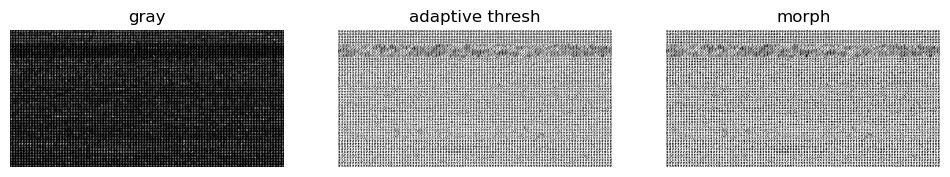

In [4]:
gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(5,5),0)
thr = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,27,10)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
morph = cv2.morphologyEx(thr, cv2.MORPH_OPEN, kernel, iterations=1)
fig,axs=plt.subplots(1,3,figsize=(12,4))
axs[0].imshow(gray,cmap='gray'); axs[0].set_title('gray'); axs[0].axis('off')
axs[1].imshow(thr,cmap='gray'); axs[1].set_title('adaptive thresh'); axs[1].axis('off')
axs[2].imshow(morph,cmap='gray'); axs[2].set_title('morph'); axs[2].axis('off'); plt.show()

### 4) Contours & boxes

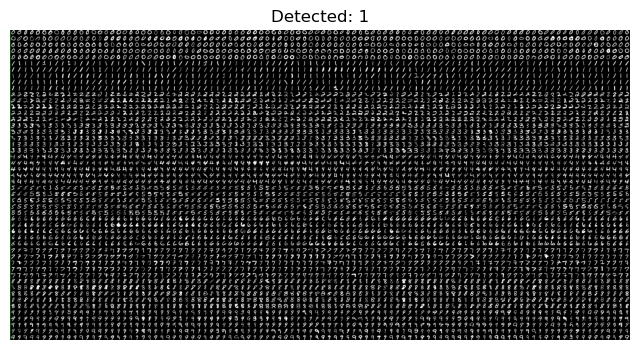

In [5]:
cnts,_=cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
boxes=[cv2.boundingRect(c) for c in cnts]
boxes=[b for b in boxes if b[2]>8 and b[3]>12]
def sort_tlbr(boxes,row_tol=12):
    boxes=sorted(boxes,key=lambda b:(b[1],b[0]))
    rows=[]; cur=[]; last=None
    for b in boxes:
        if last is None or abs(b[1]-last)<=row_tol:
            cur.append(b); last=b[1] if last is None else int(0.7*last+0.3*b[1])
        else:
            rows.append(sorted(cur,key=lambda x:x[0])); cur=[b]; last=b[1]
    if cur: rows.append(sorted(cur,key=lambda x:x[0]))
    return [b for r in rows for b in r]
boxes_sorted=sort_tlbr(boxes)
vis=cv2.cvtColor(orig.copy(), cv2.COLOR_BGR2RGB)
for (x,y,w,h) in boxes_sorted:
    cv2.rectangle(vis,(x,y),(x+w,y+h),(0,255,0),1)
plt.imshow(vis); plt.title(f'Detected: {len(boxes_sorted)}'); plt.axis('off'); plt.show()

### 5) Extract 28×28 crops

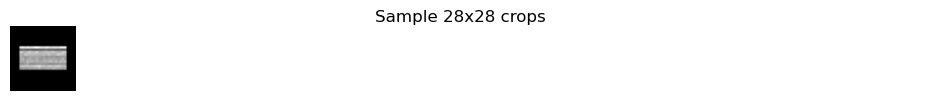

In [6]:
def extract_roi(img, b, pad=2):
    x,y,w,h=b
    x0=max(x-pad,0); y0=max(y-pad,0)
    x1=min(x+w+pad,img.shape[1]); y1=min(y+h+pad,img.shape[0])
    return img[y0:y1,x0:x1]
def to_28x28(roi):
    h,w=roi.shape
    if h>w:
        new_h=20; new_w=int(w*20/h)
    else:
        new_w=20; new_h=int(h*20/w)
    small=cv2.resize(roi,(new_w,new_h),interpolation=cv2.INTER_AREA)
    canvas=np.zeros((28,28),dtype=np.uint8)
    y0=(28-new_h)//2; x0=(28-new_w)//2
    canvas[y0:y0+new_h,x0:x0+new_w]=small
    return canvas
rois=[extract_roi(cv2.cvtColor(orig,cv2.COLOR_BGR2GRAY),b,2) for b in boxes_sorted]
crops=[to_28x28(r) for r in rois]
n=min(36,len(crops)); cols=12; rows=(n+cols-1)//cols
fig,axs=plt.subplots(rows,cols,figsize=(12,rows))
for i in range(rows*cols):
    ax=axs[i//cols, i%cols] if rows>1 else axs[i%cols]
    ax.axis('off')
    if i<n: ax.imshow(crops[i],cmap='gray')
plt.suptitle('Sample 28x28 crops'); plt.show()

### 6) CNN on MNIST (quick training)

In [7]:
from tensorflow import keras
from tensorflow.keras import layers
try:
    (mx_tr,my_tr),(mx_te,my_te)=keras.datasets.mnist.load_data()
    mx_tr=(mx_tr/255.).astype('float32')[...,None]
    mx_te=(mx_te/255.).astype('float32')[...,None]
    model=keras.Sequential([
        layers.Input((28,28,1)),
        layers.Conv2D(32,3,activation='relu'), layers.MaxPooling2D(),
        layers.Conv2D(64,3,activation='relu'), layers.MaxPooling2D(),
        layers.Flatten(), layers.Dropout(0.3),
        layers.Dense(128,activation='relu'), layers.Dense(10,activation='softmax')])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(mx_tr,my_tr,epochs=3,batch_size=256,validation_split=0.1,verbose=0)
    print('Quick MNIST test acc:', model.evaluate(mx_te,my_te,verbose=0)[1])
except Exception as e:
    print('MNIST download failed; train locally or load pre‑saved weights. Error:', e)
    model=None

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Quick MNIST test acc: 0.9868000149726868


### 7) Predict and overlay

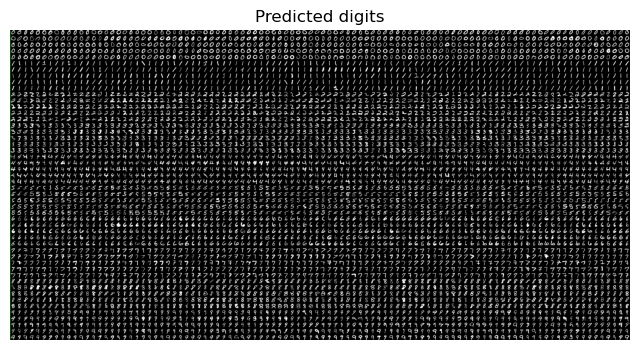

In [11]:
if 'model' in globals() and model is not None:
    Xc=(np.array(crops)/255.).astype('float32')[...,None]
    preds=model.predict(Xc,verbose=0).argmax(axis=1)
    vis=cv2.cvtColor(orig.copy(), cv2.COLOR_BGR2RGB)
    for (x,y,w,h), lab in zip(boxes_sorted, preds):
        cv2.rectangle(vis,(x,y),(x+w,y+h),(0,255,0),1)
        cv2.putText(vis,str(int(lab)),(x,y-2),cv2.FONT_HERSHEY_SIMPLEX,0.4,(255,0,0),1,cv2.LINE_AA)
    plt.imshow(vis); plt.title('Predicted digits'); plt.axis('off'); plt.show()
else:
    print('Model unavailable; skip prediction.')

### 9) Save artifacts

In [12]:
import joblib
if 'model' in globals() and model is not None:
    model.save('digits_cnn_mnist.h5')
joblib.dump(boxes_sorted,'detected_boxes.joblib')
print('Artifacts saved.')

Artifacts saved.
